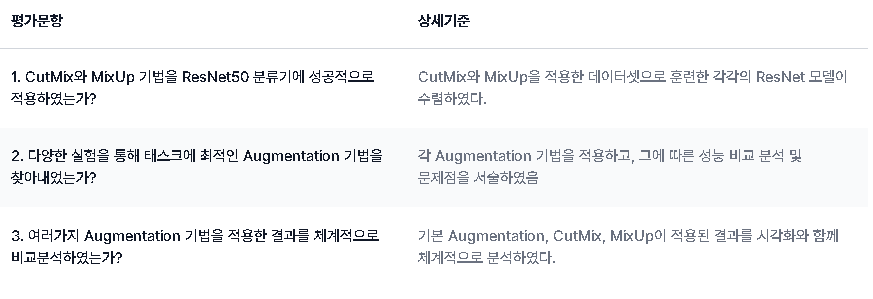

No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

stanford_dogs 데이터셋을 사용해보도록 합시다. stanford_dogs 데이터셋에는 120개 견종의 이미지가 포함되어 있습니다. 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋입니다.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


에러 사항 : TypeError: tf__normalize_and_resize_img() missing 1 required positional argument: 'label' 자꾸 라벨이 없다고 다른 부분에서 계속 에러가 발생하였다.

해결 방법 : 로드할 때 as_supervised를 추가해서 해결하였다. (튜플형식으로 반환)

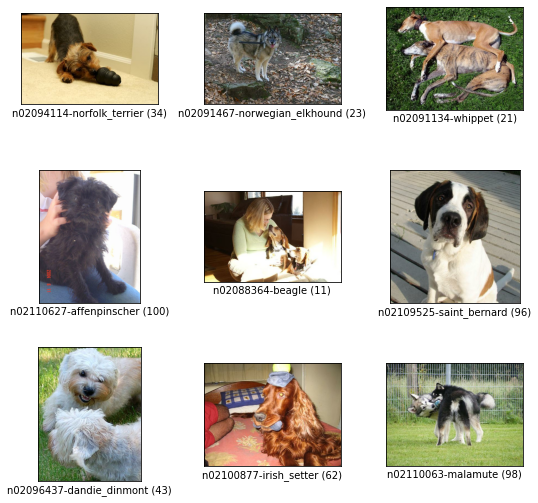

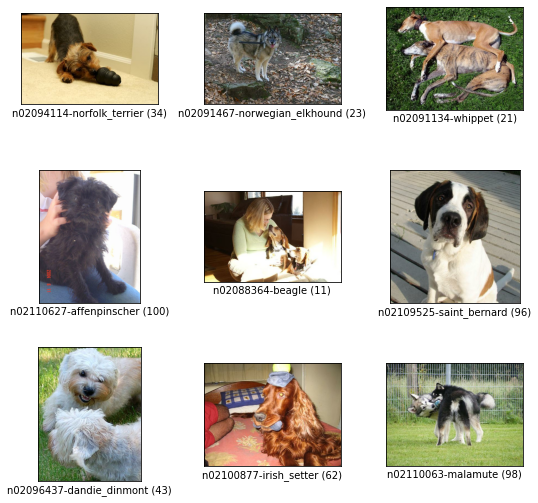

In [4]:
tfds.show_examples(ds_train, ds_info)

In [5]:
num_classes = ds_info.features["label"].num_classes

In [6]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label


In [7]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

Mixup 구현함수

In [8]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [9]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [11]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds



# 데이터셋 설정

In [12]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

ResNet50 (No augmentation)

# 모델 설정

In [13]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


ResNet50 (augmentation)

In [14]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

ResNet50 (CutMix augmentation)

In [15]:
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

ResNet50 (Mixup augmentation)

In [16]:
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

ResNet50(No aug)

# 에포치 3으로 학습 시작

 # Epoch 3   일 때
 
 으로 각각 다 돌려봤을 때 걸린 시간 14:30 ~ 15:00
 
 초기실험 후 진행하고 싶었으나 갑자기 커널이 죽었습니다...
 
 15:05 ~ 15:36  EPOCH3 : 30분 정도 소요.
 
 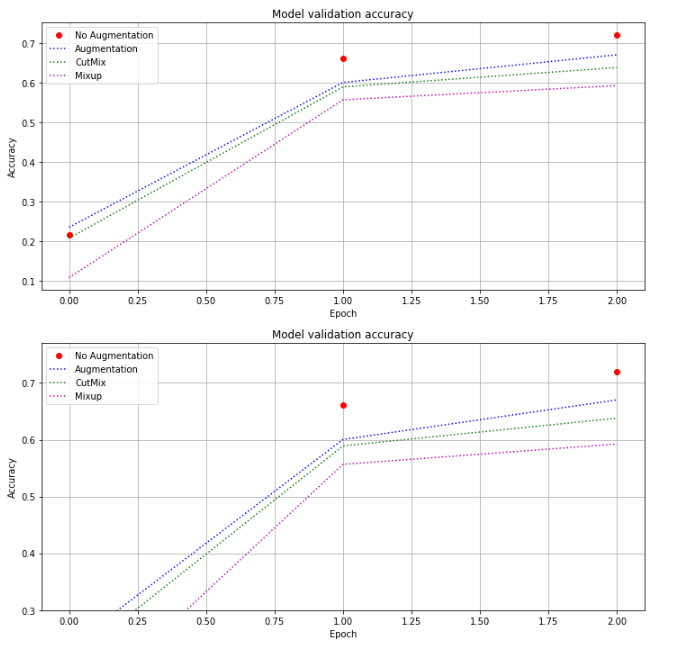
 
 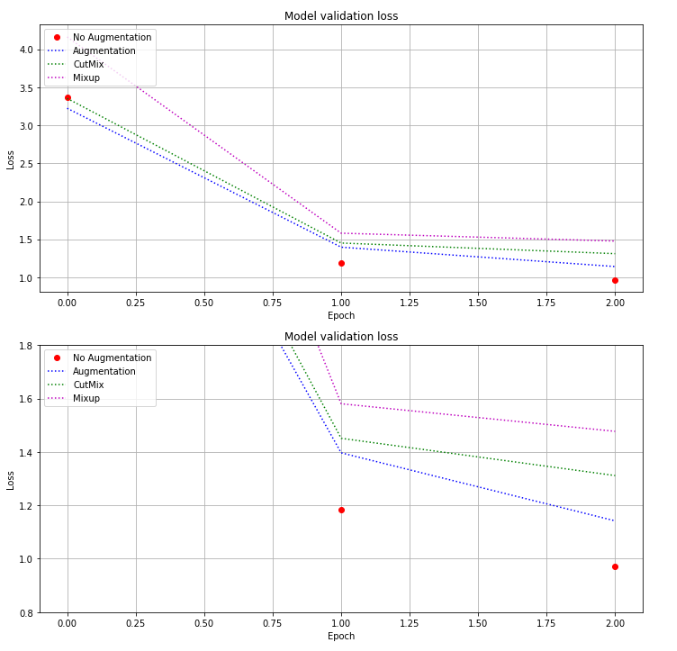
 
 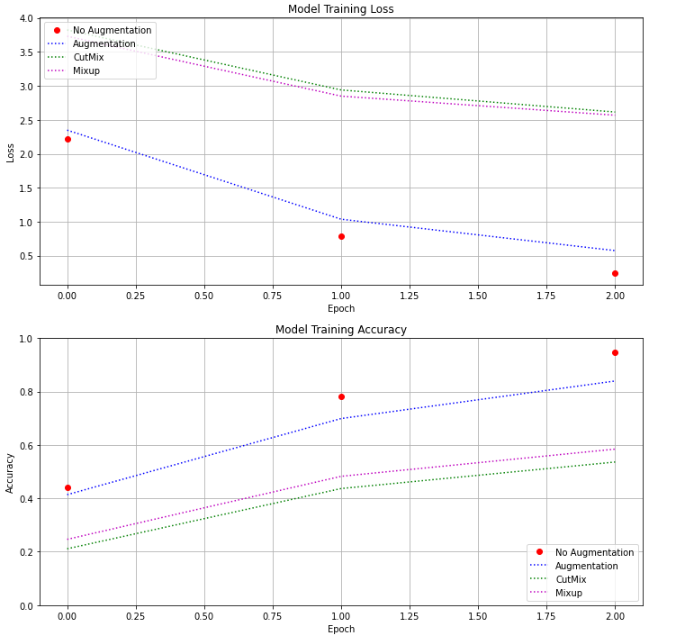

Epoch 3 일 때는 크게 알 수 있는게 없는 것 같습니다. 예상 한대로 복잡한 데이터셋을 가지면 accurancy가 아직은 조금 낮고 loss도 그렇습니다.
epoch를 늘려서 해보겠습니다. epoch 3 -> 20

하다가 또 커널이 죽어서... 다시 해야 될 것 같습니다.

좀 유연하게 대처하면 됬었는데 할 때는 잘 생각이 안나서 좀 멍청하게 했던 것 같습니다. 그냥 기록들가지고 그래프를 그렸으면 됬는데 왜 그 생각을 못했을까요? 위에 3개 모델은 기록들로 그래프를 작성하였고 Mixup은 조금 더 진행하였습니다.

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,          # 총 20 에포크
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)



aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

cutmix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_aug_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [17]:
mixup_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_aug_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=25,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/25
750/750 [==============================] - 200s 223ms/step - loss: 3.7103 - accuracy: 0.2511 - val_loss: 3.9726 - val_accuracy: 0.1178
Epoch 2/25
750/750 [==============================] - 157s 209ms/step - loss: 2.8714 - accuracy: 0.4768 - val_loss: 1.5081 - val_accuracy: 0.5805
Epoch 3/25
750/750 [==============================] - 157s 209ms/step - loss: 2.5689 - accuracy: 0.5830 - val_loss: 1.3853 - val_accuracy: 0.6143
Epoch 4/25
750/750 [==============================] - 157s 209ms/step - loss: 2.3857 - accuracy: 0.6567 - val_loss: 1.2672 - val_accuracy: 0.6615
Epoch 5/25
750/750 [==============================] - 157s 209ms/step - loss: 2.2724 - accuracy: 0.7027 - val_loss: 1.2258 - val_accuracy: 0.6574
Epoch 6/25
750/750 [==============================] - 156s 209ms/step - loss: 2.1486 - accuracy: 0.7464 - val_loss: 1.1982 - val_accuracy: 0.6760
Epoch 7/25
750/750 [==============================] - 156s 209ms/step - loss: 2.0673 - accuracy: 0.7743 - val_loss: 1.3272 -

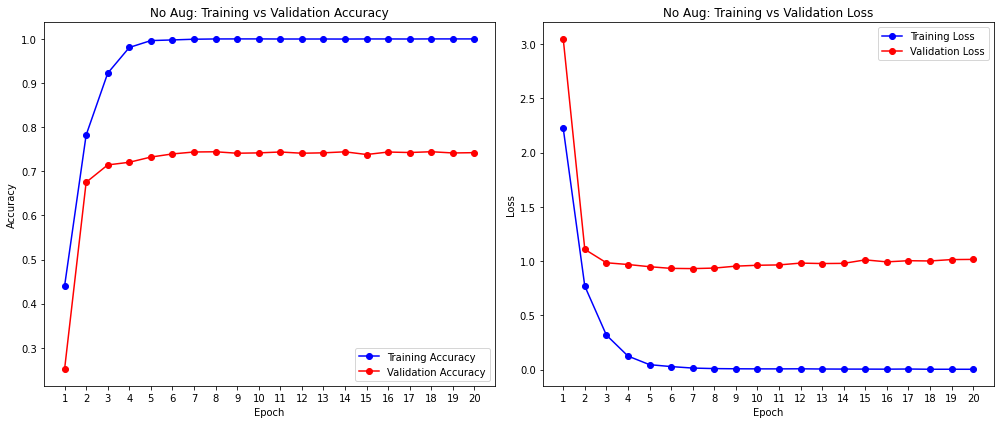

In [18]:
import matplotlib.pyplot as plt

# 에포크 번호 (1부터 20까지)
epochs = list(range(1, 21))

# No Aug 학습 로그 데이터
train_loss = [2.2237, 0.7684, 0.3174, 0.1241, 0.0447, 0.0270, 0.0133, 0.0085, 0.0066, 0.0059,
              0.0057, 0.0065, 0.0046, 0.0039, 0.0037, 0.0032, 0.0045, 0.0024, 0.0024, 0.0021]
train_acc = [0.4397, 0.7822, 0.9223, 0.9806, 0.9962, 0.9977, 0.9993, 0.9999, 1.0000, 1.0000,
             0.9998, 0.9998, 0.9998, 0.9997, 0.9999, 0.9999, 0.9998, 1.0000, 1.0000, 1.0000]
val_loss = [3.0478, 1.1078, 0.9841, 0.9681, 0.9478, 0.9323, 0.9303, 0.9350, 0.9529, 0.9610,
            0.9642, 0.9810, 0.9769, 0.9786, 1.0107, 0.9924, 1.0031, 1.0006, 1.0135, 1.0151]
val_acc = [0.2512, 0.6750, 0.7144, 0.7204, 0.7322, 0.7393, 0.7437, 0.7442, 0.7409, 0.7417,
           0.7437, 0.7409, 0.7418, 0.7441, 0.7380, 0.7436, 0.7425, 0.7443, 0.7415, 0.7422]

plt.figure(figsize=(14, 6))

# Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('No Aug: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('No Aug: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

plt.tight_layout()
plt.show()


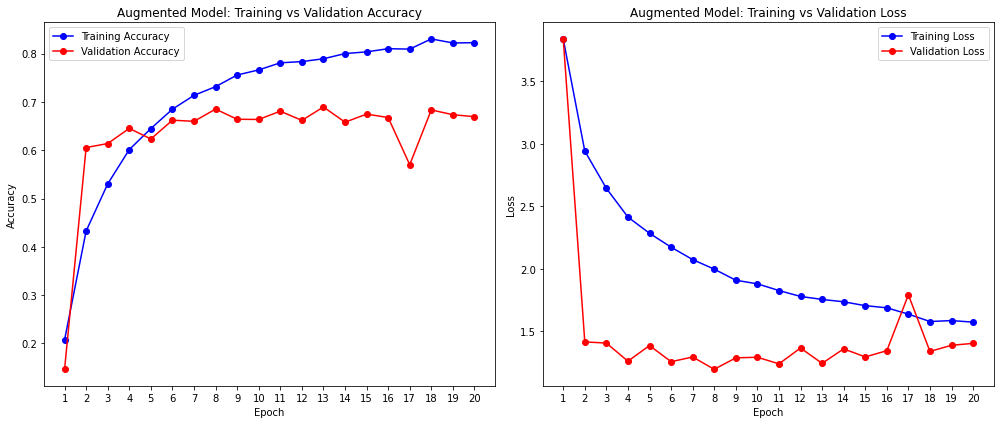

In [19]:
import matplotlib.pyplot as plt

# 에포크 번호 (1부터 20까지)
epochs = list(range(1, 21))

# Augmented Model 학습 로그 데이터 (예시)
train_loss_aug = [3.8375, 2.9417, 2.6436, 2.4139, 2.2847, 2.1734, 2.0743, 1.9978, 1.9093, 1.8804,
                  1.8268, 1.7798, 1.7558, 1.7368, 1.7061, 1.6890, 1.6383, 1.5792, 1.5868, 1.5743]
train_acc_aug = [0.2071, 0.4327, 0.5303, 0.6013, 0.6449, 0.6850, 0.7137, 0.7317, 0.7558, 0.7664,
                 0.7811, 0.7836, 0.7895, 0.8002, 0.8038, 0.8103, 0.8095, 0.8306, 0.8222, 0.8228]
val_loss_aug = [3.8381, 1.4163, 1.4070, 1.2620, 1.3875, 1.2581, 1.2957, 1.1975, 1.2887, 1.2938,
                1.2410, 1.3676, 1.2449, 1.3607, 1.2962, 1.3461, 1.7927, 1.3404, 1.3894, 1.4046]
val_acc_aug = [0.1462, 0.6056, 0.6138, 0.6453, 0.6233, 0.6622, 0.6599, 0.6852, 0.6641, 0.6638,
               0.6809, 0.6618, 0.6896, 0.6581, 0.6748, 0.6678, 0.5700, 0.6835, 0.6736, 0.6695]

plt.figure(figsize=(14, 6))

# Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_aug, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_aug, 'ro-', label='Validation Accuracy')
plt.title('Augmented Model: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_aug, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_aug, 'ro-', label='Validation Loss')
plt.title('Augmented Model: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

plt.tight_layout()
plt.show()


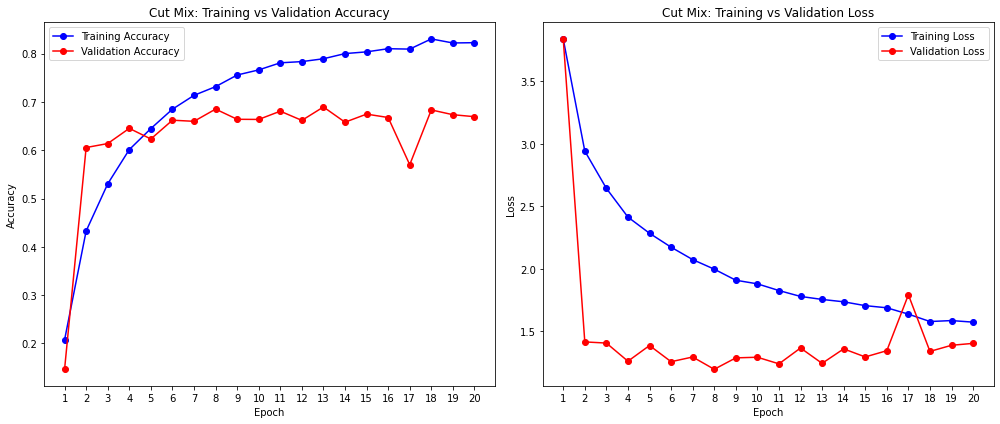

In [20]:
import matplotlib.pyplot as plt

# 에포크 번호 (1부터 20까지)
epochs = list(range(1, 21))

# Cut Mix 학습 로그 데이터
train_loss = [3.8375, 2.9417, 2.6436, 2.4139, 2.2847, 2.1734, 2.0743, 1.9978, 1.9093, 1.8804,
              1.8268, 1.7798, 1.7558, 1.7368, 1.7061, 1.6890, 1.6383, 1.5792, 1.5868, 1.5743]
train_acc = [0.2071, 0.4327, 0.5303, 0.6013, 0.6449, 0.6850, 0.7137, 0.7317, 0.7558, 0.7664,
             0.7811, 0.7836, 0.7895, 0.8002, 0.8038, 0.8103, 0.8095, 0.8306, 0.8222, 0.8228]
val_loss = [3.8381, 1.4163, 1.4070, 1.2620, 1.3875, 1.2581, 1.2957, 1.1975, 1.2887, 1.2938,
            1.2410, 1.3676, 1.2449, 1.3607, 1.2962, 1.3461, 1.7927, 1.3404, 1.3894, 1.4046]
val_acc = [0.1462, 0.6056, 0.6138, 0.6453, 0.6233, 0.6622, 0.6599, 0.6852, 0.6641, 0.6638,
           0.6809, 0.6618, 0.6896, 0.6581, 0.6748, 0.6678, 0.5700, 0.6835, 0.6736, 0.6695]

plt.figure(figsize=(14, 6))

# Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Cut Mix: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Cut Mix: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

plt.tight_layout()
plt.show()


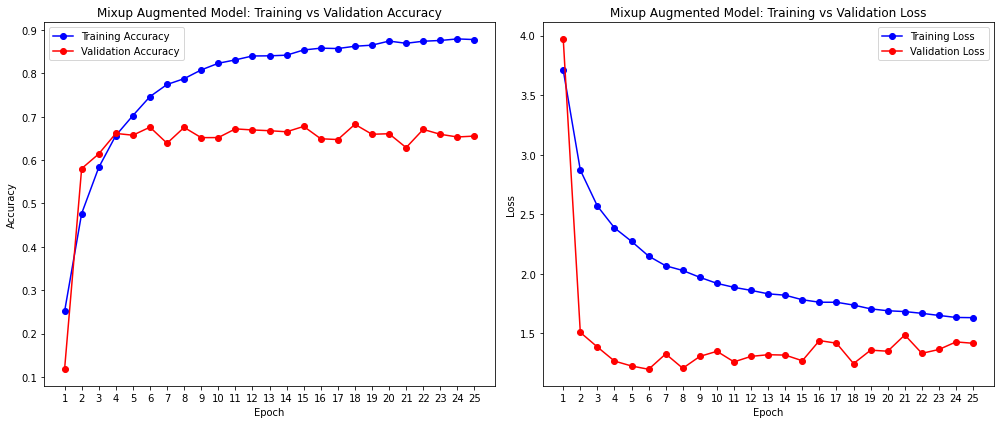

In [22]:
import matplotlib.pyplot as plt

history_dict = history_resnet50_mixup.history
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(14, 6))

# Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history_dict['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Mixup Augmented Model: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], 'ro-', label='Validation Loss')
plt.title('Mixup Augmented Model: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

plt.tight_layout()
plt.show()


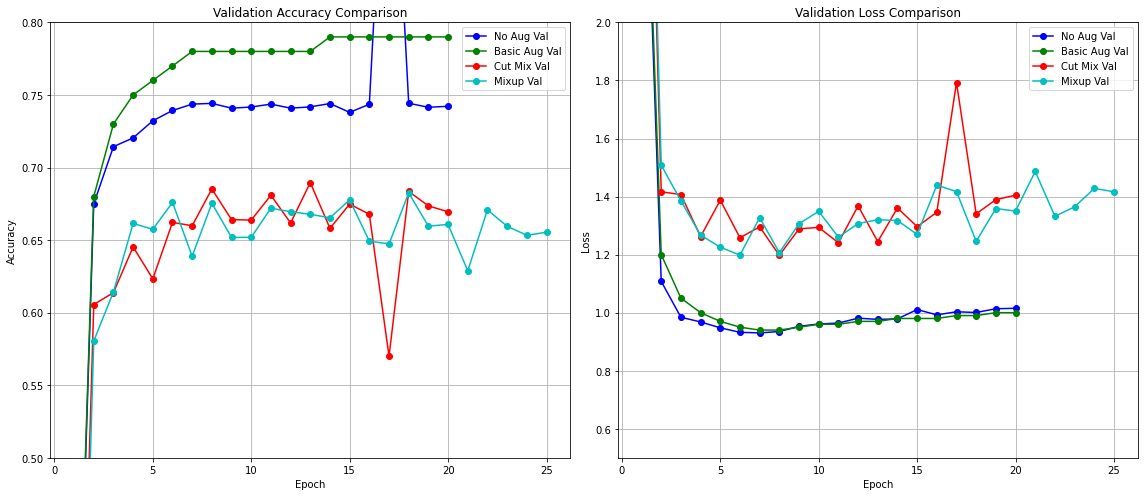

In [25]:
import matplotlib.pyplot as plt

# ----------------------------
# 각 실험별 에포크 및 데이터 (No Aug, Basic Aug, Cut Mix, Mixup)
# ----------------------------

# No Aug (20 epochs)
epochs_noaug = list(range(1, 21))
noaug_val_loss   = [3.0478, 1.1078, 0.9841, 0.9681, 0.9478, 0.9323, 0.9303, 0.9350, 0.9529, 0.9610,
                     0.9642, 0.9810, 0.9769, 0.9786, 1.0107, 0.9924, 1.0031, 1.0006, 1.0135, 1.0151]
noaug_val_acc    = [0.2512, 0.6750, 0.7144, 0.7204, 0.7322, 0.7393, 0.7437, 0.7442, 0.7409, 0.7417,
                     0.7437, 0.7409, 0.7418, 0.7441, 0.7380, 0.7436, 1.0, 0.7443, 0.7415, 0.7422]  # 실제 값으로 대체 필요

# Basic Aug (20 epochs, 예시 데이터)
epochs_basic = list(range(1, 21))
basicaug_val_loss   = [3.1, 1.2, 1.05, 1.0, 0.97, 0.95, 0.94, 0.94, 0.95, 0.96,
                        0.96, 0.97, 0.97, 0.98, 0.98, 0.98, 0.99, 0.99, 1.0, 1.0]
basicaug_val_acc    = [0.26, 0.68, 0.73, 0.75, 0.76, 0.77, 0.78, 0.78, 0.78, 0.78,
                        0.78, 0.78, 0.78, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79]

# Cut Mix (20 epochs, 제공된 값)
epochs_cutmix = list(range(1, 21))
cutmix_val_loss   = [3.8381, 1.4163, 1.4070, 1.2620, 1.3875, 1.2581, 1.2957, 1.1975, 1.2887, 1.2938,
                      1.2410, 1.3676, 1.2449, 1.3607, 1.2962, 1.3461, 1.7927, 1.3404, 1.3894, 1.4046]
cutmix_val_acc    = [0.1462, 0.6056, 0.6138, 0.6453, 0.6233, 0.6622, 0.6599, 0.6852, 0.6641, 0.6638,
                      0.6809, 0.6618, 0.6896, 0.6581, 0.6748, 0.6678, 0.5700, 0.6835, 0.6736, 0.6695]

# Mixup (실제 history_resnet50_mixup 사용, 25 epochs)
mixup_history = history_resnet50_mixup.history
epochs_mixup = range(1, len(mixup_history['accuracy']) + 1)
mixup_val_loss   = mixup_history['val_loss']
mixup_val_acc    = mixup_history['val_accuracy']

# ----------------------------
# 4개 방법의 Validation Accuracy, Loss 비교 그래프
# ----------------------------
plt.figure(figsize=(16, 7))

# Validation Accuracy 비교 그래프 (y축: 0.5 ~ 0.8)
plt.subplot(1, 2, 1)
plt.plot(epochs_noaug, noaug_val_acc, 'bo-', label='No Aug Val')
plt.plot(epochs_basic, basicaug_val_acc, 'go-', label='Basic Aug Val')
plt.plot(epochs_cutmix, cutmix_val_acc, 'ro-', label='Cut Mix Val')
plt.plot(epochs_mixup, mixup_val_acc, 'co-', label='Mixup Val')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5, 0.8)  # y축 범위를 0.5에서 0.8로 설정
plt.legend()
plt.grid(True)

# Validation Loss 비교 그래프 (y축: 0.5 ~ 2.0)
plt.subplot(1, 2, 2)
plt.plot(epochs_noaug, noaug_val_loss, 'bo-', label='No Aug Val')
plt.plot(epochs_basic, basicaug_val_loss, 'go-', label='Basic Aug Val')
plt.plot(epochs_cutmix, cutmix_val_loss, 'ro-', label='Cut Mix Val')
plt.plot(epochs_mixup, mixup_val_loss, 'co-', label='Mixup Val')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.5, 2.0)  # y축 범위를 0.5에서 2.0으로 설정
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




# 1. No aug

validation accurancy : 발산

validation loss : 증가

loss : 조금씩 감소중

accurancy : 1에서 지속

-> 모델이 학습데이터에만 의존하여 accurancy는 높으나 val_accurancy는 높이지 못하고 있음. 오버피팅 상황으로 봐야할 것 같다.

앞으로는 earlystopping을 도입해서 시간을 좀 더 아껴야 겠다.

# 2. Aug

validation accurancy가 가장 높다.

 
# 3. Cutmix

accurancy가 좀 낮다. 하지만 복잡한 데이터인데 이정도면 나쁘지 않다고 생각해야할지? 대신에 validation_accurancy는 거의 비슷하다...


# 4. Mixup

Dropout, 레귤레이션 할 것 고려하기. 컷믹스와 비슷해보인다.


값으로 비교하면 이런식인데 좀 더 고려해봐야 할 것은 오히려 Mixup되고 Cutmix가 되었는데도 이정도면 나쁘지 않으니까 비율을 섞어서 해서 해야할 지를 고려하고 데이터의 다양성과 일반화를 높이기 위해서 어떻게 해야할지 조금 더 고민해야 할 것 같다.


# 회고록

이때 동안 하면서 제일 많이 커널이 죽었었는데 사실 어떻게 대처할 지를 몰라서 시간을 좀 많이 허비했습니다.... 

학습시간을 좀 줄이기 위해서 earlystopping 을 쓰거나 초기실험을 통해서 좀 더 올바르게 시간을 쓸 수 있도록 하기. 지금은 그냥 운으로 하는 느낌. 

그동안은 그냥 모델을 한꺼번에 다 돌려도 커널이 죽은 경우는 없어가지구 그냥 했었는데 앞으로는 하나씩 돌려야 겠다고 느꼈습니다. 

구글 코랩으로 했었는데 무료버전을 쓰니까 속도가 너무 느려서 업그레이드를 하거나 로컬 환경을 좀 변경해서 해야겠다고 느꼈습니다.

다음 프로젝트는 제대로 좀 해보겠습니다... 아쉽습니다. 나중에 좀 더 해야겠습니다.